## CSC4160: Cloud Computing Final Project

Modern large-scale cloud providers such as Google Cloud, AWS, and Microsoft Azure execute millions of containerized workloads daily on shared clusters. Each submitted job requires users to specify its CPU and memory requirements before execution. However, these user-provided resource requests are often inaccurate and highly conservative. Users tend to over-request resources to be safe, resulting in underutilization and inflated costs. At the same time, aggressive under-requesting of resources would risk out-of-memory (OOM) failures, job evictions, and service-level agreement (SLA) violations.

### Feature Engineering

In [1]:
# Import necessary libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
# Import libraries for machine learning models and evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, f1_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# may need to pip install the following
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier

### **Google Cluster Trace 2019 Dataset**

The **Google Cluster Trace 2019** dataset is a large, publicly released dataset containing detailed logs from Google’s production data centers.  
It records how real workloads were scheduled, executed, and monitored across thousands of machines.

Some details include:
- CPU and memory usage sampled every few seconds  
- User-requested resources (how much CPU/memory jobs asked for)  
- Per-task and per-collection event histories  
- Task failures, evictions, and vertical scaling events  

This dataset from Google's data center provides a realistic foundation for studying workload behavior, resource inefficiency, and scheduling patterns in modern cloud systems.  

---

### **Google BigQuery**

**Google BigQuery** is a serverless, cloud-based data warehouse designed for interactive queries over extremely large datasets (TB–PB scale).  
The Google Cluster Trace is stored natively in BigQuery because the raw logs are massive—far too large for normal machines to process.

The raw Google Cluster Trace is not a ready-to-use CSV file.  
It is spread across **multiple tables**, each describing different aspects of workload execution:
- `instance_usage` → runtime CPU and memory usage  
- `instance_events` → lifecycle events (start, finish, fail, evict)  
- `collection_events` → job-level metadata  

To build a meaningful dataset for machine learning, we can join and filter these tables. BigQuery enables us to extract a combined dataset from the very large Google Cluster Trace 2019 logs.  
The SQL code to generate the dataset is found at *BigQuerySQL.txt*.


In [3]:
CSV_PATH = "~/Desktop/GoogleCloudTrace2019.csv"

In [4]:
df = pd.read_csv(CSV_PATH)

df.head()   # Display the first few rows of the dataframe

,collection_id,instance_index,machine_id,start_time,end_time,avg_cpus,avg_memory,max_cpus,max_memory,assigned_memory,page_cache_memory,cycles_per_instruction,memory_accesses_per_instruction,sample_rate,cpu_usage_distribution_json,tail_cpu_usage_distribution_json,instance_events_json,collection_events_json
0,360940137080,231,224032080418,64626000000,64627000000,0.000000,1.907349e-06,0.000000,1.907349e-06,0.0,0.000173,0.620937,0.001780,1.000000,"[0,0,0,0,0,0,0,0,0,0,0]","[0,0,0,0,0,0,0,0,0]","[{""time"":60013249940,""type"":3,""collection_id"":...","[{""time"":0,""type"":2,""collection_id"":3609401370..."
1,360940137080,1272,102892529513,2520000000000,2520300000000,0.008026,6.271362e-03,0.094360,9.826660e-03,0.0,0.001297,1.315691,0.006137,0.993333,"[0.0001239776611328125,0.00044345855712890625,...","[0.017425537109375,0.01788330078125,0.01889038...","[{""time"":2510406957821,""type"":2,""collection_id...","[{""time"":0,""type"":2,""collection_id"":3609401370..."
2,360940137080,1316,573424754,1980600000000,1980900000000,0.014206,6.965637e-03,0.062256,9.689331e-03,0.0,0.000706,2.214612,0.010292,1.000000,"[5.435943603515625e-05,0.00043582916259765625,...","[0.035888671875,0.03692626953125,0.03723144531...","[{""time"":1978725502295,""type"":3,""collection_id...","[{""time"":0,""type"":2,""collection_id"":3609401370..."
3,360940137080,174,23624515492,1568096000000,1568100000000,0.001070,3.623962e-05,0.001883,7.152557e-05,0.0,0.000033,NaN,NaN,1.000000,"[2.09808349609375e-05,2.09808349609375e-05,0.0...","[0.0018825531005859375,0.0018825531005859375,0...","[{""time"":1568086963555,""type"":3,""collection_id...","[{""time"":0,""type"":2,""collection_id"":3609401370..."
4,360940137080,194,23744499476,1289870000000,1289872000000,0.000169,9.536743e-07,0.000289,9.536743e-07,0.0,0.000664,0.927320,0.004282,1.000000,"[0,0,0,0,0,0.00014400482177734375,0.0002870559...","[0.00028705596923828125,0.00028705596923828125...","[{""time"":1288840405334,""type"":3,""collection_id...","[{""time"":0,""type"":2,""collection_id"":3609401370..."


In [5]:
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())

print("\nDtypes:")
print(df.dtypes)

Shape: (90000, 18)

Columns: ['collection_id', 'instance_index', 'machine_id', 'start_time', 'end_time', 'avg_cpus', 'avg_memory', 'max_cpus', 'max_memory', 'assigned_memory', 'page_cache_memory', 'cycles_per_instruction', 'memory_accesses_per_instruction', 'sample_rate', 'cpu_usage_distribution_json', 'tail_cpu_usage_distribution_json', 'instance_events_json', 'collection_events_json']

Dtypes:
collection_id                         int64
instance_index                        int64
machine_id                            int64
start_time                            int64
end_time                              int64
avg_cpus                            float64
avg_memory                          float64
max_cpus                            float64
max_memory                          float64
assigned_memory                     float64
page_cache_memory                   float64
cycles_per_instruction              float64
memory_accesses_per_instruction     float64
sample_rate                  

In [6]:
df["instance_key"] = (
    df["collection_id"].astype(str) + "_" +
    df["instance_index"].astype(str) + "_" +
    df["machine_id"].astype(str)
)

## Parsing Instance and Collection Events

This step converts the JSON event logs into structured columns.  
For each instance, we extract key fields (e.g., event time, event type, requested CPUs/memory, scheduling class, priority) from the **last instance event**, which reflects the container’s final state.  
We also extract job-level metadata (e.g., user, collection name, scheduler) from the **first collection event**.  
These parsed fields are expanded into separate DataFrames and joined back to the main dataset to create `df_expanded`, which includes both usage metrics and scheduler-visible features.


In [7]:

# ---------- 1) INSTANCE EVENTS ----------

def parse_instance_events(events_json_str):
    """
    Parse instance_events_json and return a dict of columns:
      - event_time (time of last event)
      - instance_events_type (last event type)
      - scheduling_class, collection_type, priority, alloc_collection_id,
        instance_index, machine_id
      - resource_request_cpus, resource_request_memory
      - constraint (stringified)
      - failed (1 if last event type == 4, else 0)
    """
    if pd.isna(events_json_str):
        return {}

    try:
        events = json.loads(events_json_str)
    except json.JSONDecodeError:
        return {}

    if not events:
        return {}

    # helper: safely get time as int
    def get_time(e):
        t = e.get("time", 0)
        try:
            return int(t)
        except (TypeError, ValueError):
            return 0

    # choose the last event by numeric time
    last_event = max(events, key=get_time)

    res_req = last_event.get("resource_request") or {}

    return {
        "event_time": get_time(last_event),
        "instance_events_type": last_event.get("type"),
        "scheduling_class": last_event.get("scheduling_class"),
        "collection_type": last_event.get("collection_type"),
        "priority": last_event.get("priority"),
        "alloc_collection_id": last_event.get("alloc_collection_id"),
        "instance_index": last_event.get("instance_index"),
        "machine_id": last_event.get("machine_id"),
        "resource_request_cpus": res_req.get("cpus"),
        "resource_request_memory": res_req.get("memory"),
        "constraint": str(last_event.get("constraint")),
        # instance failure: last event type == 4
        "failed": int(last_event.get("type") == 4),
    }

instance_events_df = (
    df["instance_events_json"]
    .apply(parse_instance_events)
    .apply(pd.Series)
)

# ---------- 2) COLLECTION EVENTS ----------

def parse_collection_events(events_json_str):
    """
    Parse collection_events_json and return a dict of columns from
    the earliest event (by time).
    """
    if pd.isna(events_json_str):
        return {}

    try:
        events = json.loads(events_json_str)
    except json.JSONDecodeError:
        return {}

    if not events:
        return {}

    # helper: safely get time as int
    def get_time(e):
        t = e.get("time", 0)
        try:
            return int(t)
        except (TypeError, ValueError):
            return 0

    # choose the earliest event by time
    first_event = min(events, key=get_time)

    return {
        "collection_events_type": first_event.get("type"),
        "user": first_event.get("user"),
        "collection_name": first_event.get("collection_name"),
        "collection_logical_name": first_event.get("collection_logical_name"),
        "start_after_collection_ids": first_event.get("start_after_collection_ids"),
        "vertical_scaling": first_event.get("vertical_scaling"),
        "scheduler": first_event.get("scheduler"),
    }

collection_events_df = (
    df["collection_events_json"]
    .apply(parse_collection_events)
    .apply(pd.Series)
)

# ---------- 3) CONCAT BACK ----------

df_expanded = pd.concat([df, instance_events_df, collection_events_df], axis=1)


In [8]:
# Remove duplicated columns by name (keep first occurrence)
df_expanded = df_expanded.loc[:, ~df_expanded.columns.duplicated()]

pd.set_option("display.max_columns", None)
df_expanded.head()

,collection_id,instance_index,machine_id,start_time,end_time,avg_cpus,avg_memory,max_cpus,max_memory,assigned_memory,page_cache_memory,cycles_per_instruction,memory_accesses_per_instruction,sample_rate,cpu_usage_distribution_json,tail_cpu_usage_distribution_json,instance_events_json,collection_events_json,instance_key,event_time,instance_events_type,scheduling_class,collection_type,priority,alloc_collection_id,resource_request_cpus,resource_request_memory,constraint,failed,collection_events_type,user,collection_name,collection_logical_name,start_after_collection_ids,vertical_scaling,scheduler
0,360940137080,231,224032080418,64626000000,64627000000,0.000000,1.907349e-06,0.000000,1.907349e-06,0.0,0.000173,0.620937,0.001780,1.000000,"[0,0,0,0,0,0,0,0,0,0,0]","[0,0,0,0,0,0,0,0,0]","[{""time"":60013249940,""type"":3,""collection_id"":...","[{""time"":0,""type"":2,""collection_id"":3609401370...",360940137080_231_224032080418,64621913266,7,2,0,360,330587162970,0.010330,0.001303,[],0,2,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,myqRrKor4KVGEA9s99pmSbf4odjAvSrKCa+6qLdhRJM=,wcRcAMuop2OqH9EW4feH919tadFec5a11ply0hcS/C8=,[],2,0
1,360940137080,1272,102892529513,2520000000000,2520300000000,0.008026,6.271362e-03,0.094360,9.826660e-03,0.0,0.001297,1.315691,0.006137,0.993333,"[0.0001239776611328125,0.00044345855712890625,...","[0.017425537109375,0.01788330078125,0.01889038...","[{""time"":2510406957821,""type"":2,""collection_id...","[{""time"":0,""type"":2,""collection_id"":3609401370...",360940137080_1272_102892529513,2533370736578,4,2,0,360,330587162970,0.009171,0.001303,[],1,2,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,myqRrKor4KVGEA9s99pmSbf4odjAvSrKCa+6qLdhRJM=,wcRcAMuop2OqH9EW4feH919tadFec5a11ply0hcS/C8=,[],2,0
2,360940137080,1316,573424754,1980600000000,1980900000000,0.014206,6.965637e-03,0.062256,9.689331e-03,0.0,0.000706,2.214612,0.010292,1.000000,"[5.435943603515625e-05,0.00043582916259765625,...","[0.035888671875,0.03692626953125,0.03723144531...","[{""time"":1978725502295,""type"":3,""collection_id...","[{""time"":0,""type"":2,""collection_id"":3609401370...",360940137080_1316_573424754,1983060125438,7,2,0,360,330587162970,0.011490,0.001303,[],0,2,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,myqRrKor4KVGEA9s99pmSbf4odjAvSrKCa+6qLdhRJM=,wcRcAMuop2OqH9EW4feH919tadFec5a11ply0hcS/C8=,[],2,0
3,360940137080,174,23624515492,1568096000000,1568100000000,0.001070,3.623962e-05,0.001883,7.152557e-05,0.0,0.000033,NaN,NaN,1.000000,"[2.09808349609375e-05,2.09808349609375e-05,0.0...","[0.0018825531005859375,0.0018825531005859375,0...","[{""time"":1568086963555,""type"":3,""collection_id...","[{""time"":0,""type"":2,""collection_id"":3609401370...",360940137080_174_23624515492,1568734025052,7,2,0,360,330587162970,0.011490,0.001303,[],0,2,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,myqRrKor4KVGEA9s99pmSbf4odjAvSrKCa+6qLdhRJM=,wcRcAMuop2OqH9EW4feH919tadFec5a11ply0hcS/C8=,[],2,0
4,360940137080,194,23744499476,1289870000000,1289872000000,0.000169,9.536743e-07,0.000289,9.536743e-07,0.0,0.000664,0.927320,0.004282,1.000000,"[0,0,0,0,0,0.00014400482177734375,0.0002870559...","[0.00028705596923828125,0.00028705596923828125...","[{""time"":1288840405334,""type"":3,""collection_id...","[{""time"":0,""type"":2,""collection_id"":3609401370...",360940137080_194_23744499476,1289871180103,7,2,0,360,330587162970,0.011490,0.001303,[],0,2,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,myqRrKor4KVGEA9s99pmSbf4odjAvSrKCa+6qLdhRJM=,wcRcAMuop2OqH9EW4feH919tadFec5a11ply0hcS/C8=,[],2,0


In [9]:
df_expanded.columns

Index(['collection_id', 'instance_index', 'machine_id', 'start_time',
       'end_time', 'avg_cpus', 'avg_memory', 'max_cpus', 'max_memory',
       'assigned_memory', 'page_cache_memory', 'cycles_per_instruction',
       'memory_accesses_per_instruction', 'sample_rate',
       'cpu_usage_distribution_json', 'tail_cpu_usage_distribution_json',
       'instance_events_json', 'collection_events_json', 'instance_key',
       'event_time', 'instance_events_type', 'scheduling_class',
       'collection_type', 'priority', 'alloc_collection_id',
       'resource_request_cpus', 'resource_request_memory', 'constraint',
       'failed', 'collection_events_type', 'user', 'collection_name',
       'collection_logical_name', 'start_after_collection_ids',
       'vertical_scaling', 'scheduler'],
      dtype='object')

#### Column Description: <br>
collection_id – Unique identifier of the collection (job) the instance belongs to.<br>
instance_index – Index of the instance within the collection.<br>
machine_id – ID of the machine where this instance executed.<br>
start_time – Timestamp of the first recorded usage sample (nanoseconds since epoch).<br>
end_time – Timestamp of the last recorded usage sample (nanoseconds since epoch).<br>
avg_cpus – Average CPU usage over the sampling window.<br>
avg_memory – Average memory usage over the sampling window.<br>
max_cpus – Maximum CPU usage observed.<br>
max_memory – Maximum memory usage observed.<br>
assigned_memory – Memory reserved for this instance by the scheduler.<br>
page_cache_memory – Amount of page cache memory used by the instance.<br>
cycles_per_instruction – CPI (cycles per instruction), measuring CPU efficiency.<br>
memory_accesses_per_instruction – Memory access intensity (MAI).<br>
sample_rate – Frequency at which usage statistics were sampled.<br>
cpu_usage_distribution_json – Histogram of CPU usage distribution (JSON encoded).<br>
tail_cpu_usage_distribution_json – Histogram of high-percentile CPU usage (JSON encoded).<br>
instance_events_json – Raw JSON list of lifecycle events for the instance.<br>
collection_events_json – Raw JSON list of lifecycle events for the collection.<br>
event_time – Timestamp of the final instance event (based on maximum event time).<br>
instance_events_type – Type code of the final instance event.<br>
scheduling_class – Scheduler-assigned class indicating job importance and sensitivity.<br>
collection_type – System-defined type/classification of the collection.<br>
priority – Job priority assigned by the scheduler or user.<br>
alloc_collection_id – Collection ID used internally by the resource allocator.<br>
instance_index – Duplicate instance index extracted from instance-event JSON.<br>
machine_id – Duplicate machine ID extracted from instance-event JSON.<br>
resource_request_cpus – CPU quantity originally requested by the instance.<br>
resource_request_memory – Memory quantity originally requested by the instance.<br>
constraint – Scheduling/placement constraints applied to the instance.<br>
failed – Indicator of instance failure (1 if final event type is 4, else 0).<br>
collections_events_type – Type code of the first collection-level event.<br>
user – Hashed identifier of the user owning the collection.<br>
collection_name – Hashed name of the collection.<br>
collection_logical_name – Hashed logical name of the collection.<br>
start_after_collection_ids – List of prerequisite collections that must finish first.<br>
vertical_scaling – Setting indicating whether vertical scaling is allowed for the collection.<br>
scheduler – Identifier of the scheduler that handled this collection.<br>

### From existing columns, we can derive more columns via calculation

In [10]:

def safe_div(a, b):
    # Elementwise safe division: returns NaN where b is 0 or NaN
    return np.where((b != 0) & (~np.isnan(b)), a / b, np.nan)

# --- Duration features ---
df_expanded["duration_us"] = df_expanded["end_time"] - df_expanded["start_time"]
df_expanded["duration_s"] = df_expanded["duration_us"] / 1e6
df_expanded["log_duration_s"] = np.log1p(df_expanded["duration_s"])

# --- Request vs usage ---
df_expanded["cpu_req_util"] = safe_div(
    df_expanded["avg_cpus"],
    df_expanded["resource_request_cpus"],
)
df_expanded["mem_req_util"] = safe_div(
    df_expanded["avg_memory"],
    df_expanded["resource_request_memory"],
)
df_expanded["cpu_over_request"] = (
    df_expanded["resource_request_cpus"] - df_expanded["avg_cpus"]
)
df_expanded["mem_over_request"] = (
    df_expanded["resource_request_memory"] - df_expanded["avg_memory"]
)

# --- Burstiness ---
df_expanded["cpu_peak_to_avg"] = safe_div(
    df_expanded["max_cpus"],
    df_expanded["avg_cpus"],
)
df_expanded["mem_peak_to_avg"] = safe_div(
    df_expanded["max_memory"],
    df_expanded["avg_memory"],
)

# --- Efficiency & workload shape ---
df_expanded["cpu_efficiency_proxy"] = safe_div(
    1.0,
    df_expanded["cycles_per_instruction"],
)
df_expanded["mem_intensity_ratio"] = safe_div(
    df_expanded["memory_accesses_per_instruction"],
    df_expanded["cycles_per_instruction"],
)
df_expanded["cpu_to_mem_usage"] = safe_div(
    df_expanded["avg_cpus"],
    df_expanded["avg_memory"],
)

# --- Page cache behavior ---
df_expanded["page_cache_fraction"] = safe_div(
    df_expanded["page_cache_memory"],
    df_expanded["assigned_memory"],
)

# --- Failure-related ---
df_expanded["failure_prone_class"] = (
    df_expanded["scheduling_class"] * df_expanded["failed"]
)

# --- Workload shape ---
df_expanded["cpu_to_mem_request"] = safe_div(
    df_expanded["resource_request_cpus"],
    df_expanded["resource_request_memory"],
)
df_expanded["avg_usage_skew"] = (
    df_expanded["avg_cpus"] - df_expanded["avg_memory"]
)
df_expanded["peak_usage_skew"] = (
    df_expanded["max_cpus"] - df_expanded["max_memory"]
)


In [11]:
df_expanded.head()

,collection_id,instance_index,machine_id,start_time,end_time,avg_cpus,avg_memory,max_cpus,max_memory,assigned_memory,page_cache_memory,cycles_per_instruction,memory_accesses_per_instruction,sample_rate,cpu_usage_distribution_json,tail_cpu_usage_distribution_json,instance_events_json,collection_events_json,instance_key,event_time,instance_events_type,scheduling_class,collection_type,priority,alloc_collection_id,resource_request_cpus,resource_request_memory,constraint,failed,collection_events_type,user,collection_name,collection_logical_name,start_after_collection_ids,vertical_scaling,scheduler,duration_us,duration_s,log_duration_s,cpu_req_util,mem_req_util,cpu_over_request,mem_over_request,cpu_peak_to_avg,mem_peak_to_avg,cpu_efficiency_proxy,mem_intensity_ratio,cpu_to_mem_usage,page_cache_fraction,failure_prone_class,cpu_to_mem_request,avg_usage_skew,peak_usage_skew
0,360940137080,231,224032080418,64626000000,64627000000,0.000000,1.907349e-06,0.000000,1.907349e-06,0.0,0.000173,0.620937,0.001780,1.000000,"[0,0,0,0,0,0,0,0,0,0,0]","[0,0,0,0,0,0,0,0,0]","[{""time"":60013249940,""type"":3,""collection_id"":...","[{""time"":0,""type"":2,""collection_id"":3609401370...",360940137080_231_224032080418,64621913266,7,2,0,360,330587162970,0.010330,0.001303,[],0,2,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,myqRrKor4KVGEA9s99pmSbf4odjAvSrKCa+6qLdhRJM=,wcRcAMuop2OqH9EW4feH919tadFec5a11ply0hcS/C8=,[],2,0,1000000,1.0,0.693147,0.000000,0.001464,0.010330,0.001301,NaN,1.000000,1.610468,0.002867,0.000000,NaN,0,7.929722,-0.000002,-0.000002
1,360940137080,1272,102892529513,2520000000000,2520300000000,0.008026,6.271362e-03,0.094360,9.826660e-03,0.0,0.001297,1.315691,0.006137,0.993333,"[0.0001239776611328125,0.00044345855712890625,...","[0.017425537109375,0.01788330078125,0.01889038...","[{""time"":2510406957821,""type"":2,""collection_id...","[{""time"":0,""type"":2,""collection_id"":3609401370...",360940137080_1272_102892529513,2533370736578,4,2,0,360,330587162970,0.009171,0.001303,[],1,2,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,myqRrKor4KVGEA9s99pmSbf4odjAvSrKCa+6qLdhRJM=,wcRcAMuop2OqH9EW4feH919tadFec5a11ply0hcS/C8=,[],2,0,300000000,300.0,5.707110,0.875208,4.814056,0.001144,-0.004969,11.756654,1.566910,0.760057,0.004664,1.279805,NaN,2,7.039531,0.001755,0.084534
2,360940137080,1316,573424754,1980600000000,1980900000000,0.014206,6.965637e-03,0.062256,9.689331e-03,0.0,0.000706,2.214612,0.010292,1.000000,"[5.435943603515625e-05,0.00043582916259765625,...","[0.035888671875,0.03692626953125,0.03723144531...","[{""time"":1978725502295,""type"":3,""collection_id...","[{""time"":0,""type"":2,""collection_id"":3609401370...",360940137080_1316_573424754,1983060125438,7,2,0,360,330587162970,0.011490,0.001303,[],0,2,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,myqRrKor4KVGEA9s99pmSbf4odjAvSrKCa+6qLdhRJM=,wcRcAMuop2OqH9EW4feH919tadFec5a11ply0hcS/C8=,[],2,0,300000000,300.0,5.707110,1.236388,5.346999,-0.002716,-0.005663,4.382385,1.391019,0.451546,0.004647,2.039430,NaN,0,8.819912,0.007240,0.052567
3,360940137080,174,23624515492,1568096000000,1568100000000,0.001070,3.623962e-05,0.001883,7.152557e-05,0.0,0.000033,NaN,NaN,1.000000,"[2.09808349609375e-05,2.09808349609375e-05,0.0...","[0.0018825531005859375,0.0018825531005859375,0...","[{""time"":1568086963555,""type"":3,""collection_id...","[{""time"":0,""type"":2,""collection_id"":3609401370...",360940137080_174_23624515492,1568734025052,7,2,0,360,330587162970,0.011490,0.001303,[],0,2,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,myqRrKor4KVGEA9s99pmSbf4odjAvSrKCa+6qLdhRJM=,wcRcAMuop2OqH9EW4feH919tadFec5a11ply0hcS/C8=,[],2,0,4000000,4.0,1.609438,0.093127,0.027818,0.010420,0.001266,1.759358,1.973684,NaN,NaN,29.526316,NaN,0,8.819912,0.001034,0.001811
4,360940137080,194,23744499476,1289870000000,1289872000000,0.000169,9.536743e-07,0.000289,9.536743e-07,0.0,0.000664,0.927320,0.004282,1.000000,"[0,0,0,0,0,0.00014400482177734375,0.0002870559...","[0.00028705596923828125,0.00028705596923828125...","[{""time"":1288840405

In [12]:
df_expanded.columns

Index(['collection_id', 'instance_index', 'machine_id', 'start_time',
       'end_time', 'avg_cpus', 'avg_memory', 'max_cpus', 'max_memory',
       'assigned_memory', 'page_cache_memory', 'cycles_per_instruction',
       'memory_accesses_per_instruction', 'sample_rate',
       'cpu_usage_distribution_json', 'tail_cpu_usage_distribution_json',
       'instance_events_json', 'collection_events_json', 'instance_key',
       'event_time', 'instance_events_type', 'scheduling_class',
       'collection_type', 'priority', 'alloc_collection_id',
       'resource_request_cpus', 'resource_request_memory', 'constraint',
       'failed', 'collection_events_type', 'user', 'collection_name',
       'collection_logical_name', 'start_after_collection_ids',
       'vertical_scaling', 'scheduler', 'duration_us', 'duration_s',
       'log_duration_s', 'cpu_req_util', 'mem_req_util', 'cpu_over_request',
       'mem_over_request', 'cpu_peak_to_avg', 'mem_peak_to_avg',
       'cpu_efficiency_proxy', 'mem_in

### Extract the useful columns / features to fit into ML model

The variables in `selected_features` were chosen because they directly relate to
resource usage and are relevant for understanding how a workload behaves.
They fall into three useful categories:

1. **Requested resources and scheduler inputs**  
   These fields reflect what the scheduler knows at submission time
   (requested CPUs/memory, priority, scheduling_class).  
   They are meaningful predictors and directly influence scheduling decisions.

2. **Actual usage metrics**  
   Runtime CPU/memory usage (avg/peak) and hardware counters (CPI/MAI) 
   describe how the container behaved once it started running.  
   These provide an upper bound on model performance and help quantify 
   inefficiency and over-provisioning.

3. **Derived ratios and efficiency indicators**  
   Ratios such as over-requesting, peak-to-average usage, CPU–memory balance, 
   and page-cache fractions capture workload efficiency more accurately than 
   raw values.

Other metadata in the raw trace (e.g., long IDs, string labels, timestamps, 
miscellaneous event fields) was not included because it does not directly 
contribute to resource behavior or prediction, and often adds noise rather than 
signal.


In [13]:
selected_features = [
    "resource_request_cpus", "resource_request_memory", "assigned_memory",
    "scheduling_class", "priority",
    "avg_cpus", "avg_memory", "max_cpus", "max_memory", "page_cache_memory",
    "cycles_per_instruction", "memory_accesses_per_instruction", "sample_rate",
    "duration_s", "log_duration_s", "cpu_req_util", "mem_req_util",
    "cpu_over_request", "mem_over_request", "cpu_peak_to_avg", "mem_peak_to_avg",
    "cpu_efficiency_proxy", "mem_intensity_ratio", "cpu_to_mem_usage",
    "page_cache_fraction", "cpu_to_mem_request", "avg_usage_skew",
    "peak_usage_skew",
]


### Random Forest

### Train/Test Split for Baseline Modeling

In this step, we prepare the dataset for a simple predictive experiment using
the expanded feature set. We select one variable (e.g., `avg_cpus`) as the
prediction target and use the remaining engineered features as inputs.

The target variable is removed from the feature
list. The dataset is then split into training and testing subsets using an
80/20 split. This allows us to evaluate how well a model trained on past
instances can generalize to unseen containers.


In [14]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = df_expanded.copy()

# Choose target:
target = "avg_cpus"   # change to "avg_memory" or "failed"

# Avoid leakage:
features = [c for c in selected_features if c != target]

X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [15]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, f1_score

if target != "failed":
    rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=14,
        random_state=42
    )
else:
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=14,
        class_weight="balanced",
        random_state=42
    )

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("\nRANDOM FOREST RESULTS:")
if target != "failed":
    print("MAE:", mean_absolute_error(y_test, rf_pred))
    print("R2:", r2_score(y_test, rf_pred))
else:
    print("Accuracy:", accuracy_score(y_test, rf_pred))
    print("F1:", f1_score(y_test, rf_pred))



RANDOM FOREST RESULTS:
MAE: 5.197813269890489e-05
R2: 0.9992628965151621


In [16]:
rf_importances = rf.feature_importances_
rf_sorted_idx = np.argsort(rf_importances)[::-1]

print("\nRandom Forest — Top 20 Feature Importances:")
for idx in rf_sorted_idx[:20]:
    print(f"{features[idx]}: {rf_importances[idx]:.5f}")



Random Forest — Top 20 Feature Importances:
avg_usage_skew: 0.81551
max_cpus: 0.09469
avg_memory: 0.05577
cpu_to_mem_usage: 0.00867
mem_req_util: 0.00773
max_memory: 0.00573
cpu_over_request: 0.00468
cpu_req_util: 0.00418
cpu_peak_to_avg: 0.00121
resource_request_cpus: 0.00048
resource_request_memory: 0.00048
mem_over_request: 0.00022
cpu_to_mem_request: 0.00014
mem_peak_to_avg: 0.00010
peak_usage_skew: 0.00009
page_cache_memory: 0.00007
memory_accesses_per_instruction: 0.00007
cycles_per_instruction: 0.00005
cpu_efficiency_proxy: 0.00005
mem_intensity_ratio: 0.00004


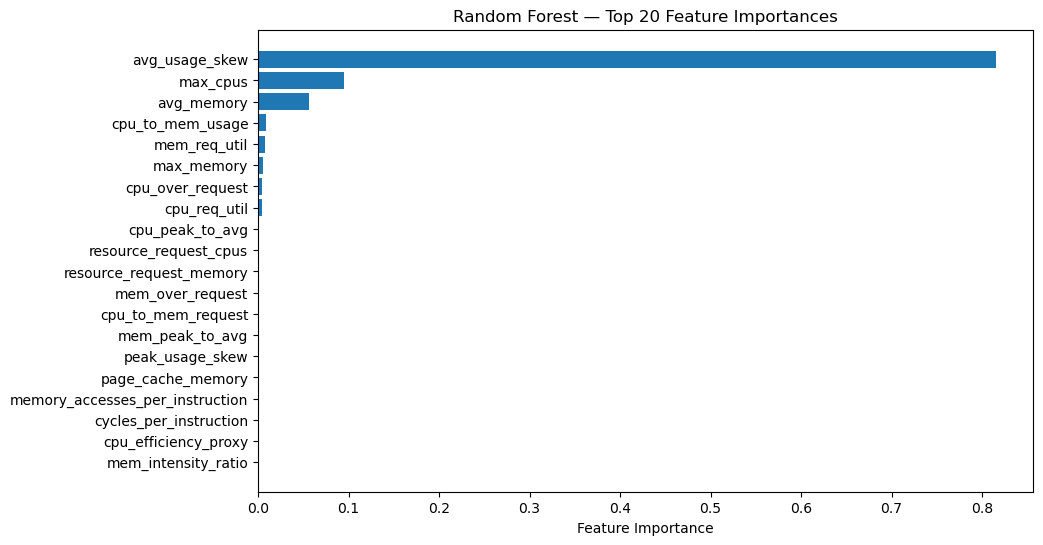

In [17]:
# Get top 20 indices
top_n = 20
top_idx = np.argsort(rf_importances)[::-1][:top_n]

# Extract feature names and importance values
top_features = [features[i] for i in top_idx]
top_values = rf_importances[top_idx]

plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_values)
plt.yticks(range(top_n), top_features)
plt.xlabel("Feature Importance")
plt.title("Random Forest — Top 20 Feature Importances")
plt.gca().invert_yaxis()  # So the highest importance appears at the top
plt.show()

### Training XGBoost Model

XGBoost is used because it handles non-linear relationships, mixed feature
scales, missing values, and complex feature interactions effectively. It is
well-suited for tabular datasets like the Google Cluster Trace and provides
strong performance with relatively little tuning.

If the target variable is continuous, we use `XGBRegressor`; if the target is
binary (e.g., failure prediction), we switch to `XGBClassifier`. After fitting
the model on the training split, we evaluate it on the test set using standard
metrics.

In [18]:
from xgboost import XGBRegressor, XGBClassifier


df = df_expanded.copy()

# Choose target:
target = "avg_cpus" 

# Avoid leakage:
features = [c for c in selected_features if c != target]

X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


if target != "failed":
    xgb = XGBRegressor(
        n_estimators=300,
        max_depth=10,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method="hist"
    )
else:
    xgb = XGBClassifier(
        n_estimators=300,
        max_depth=10,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=10,   # handle imbalance
        random_state=42,
        tree_method="hist"
    )

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

print("\nXGBOOST RESULTS:")
if target != "failed":
    print("MAE:", mean_absolute_error(y_test, xgb_pred))
    print("R2:", r2_score(y_test, xgb_pred))
else:
    print("Accuracy:", accuracy_score(y_test, xgb_pred))
    print("F1:", f1_score(y_test, xgb_pred))



XGBOOST RESULTS:
MAE: 0.00012222455063385415
R2: 0.9936104964272965


In [19]:
xgb_importances = xgb.get_booster().get_score(importance_type='gain')

# convert to sorted list
xgb_fi = sorted(xgb_importances.items(), key=lambda x: x[1], reverse=True)

print("\nXGBoost — Top 20 Feature Importances (gain):")
for feature, score in xgb_fi[:20]:
    print(f"{feature}: {score:.5f}")



XGBoost — Top 20 Feature Importances (gain):
avg_usage_skew: 0.01668
max_cpus: 0.00854
peak_usage_skew: 0.00212
cpu_over_request: 0.00210
priority: 0.00128
avg_memory: 0.00113
resource_request_memory: 0.00102
scheduling_class: 0.00082
max_memory: 0.00076
cpu_to_mem_usage: 0.00059
mem_req_util: 0.00058
cpu_peak_to_avg: 0.00057
cpu_to_mem_request: 0.00045
cpu_req_util: 0.00032
resource_request_cpus: 0.00030
mem_over_request: 0.00023
mem_peak_to_avg: 0.00012
sample_rate: 0.00010
page_cache_memory: 0.00008
cycles_per_instruction: 0.00007


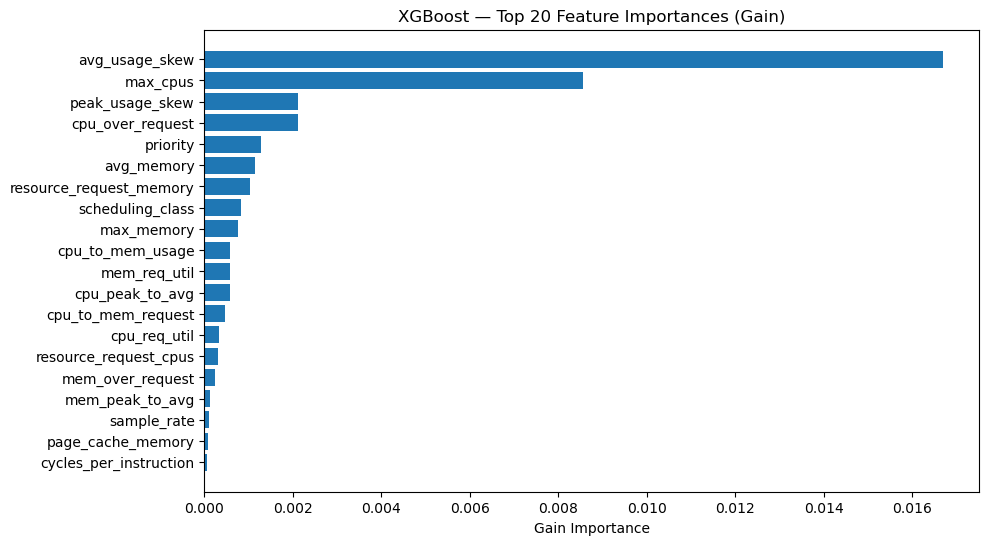

In [20]:
# Convert XGBoost importance dict to lists
feat_names = []
feat_scores = []

for feature, score in xgb_fi[:20]:  # top 20 already sorted
    feat_names.append(feature)
    feat_scores.append(score)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(feat_scores)), feat_scores)
plt.yticks(range(len(feat_scores)), feat_names)
plt.xlabel("Gain Importance")
plt.title("XGBoost — Top 20 Feature Importances (Gain)")
plt.gca().invert_yaxis()  # highest importance at top
plt.show()

LightGBM is added as a third model because it is fast, handles large feature sets
well, and often performs better than both Random Forest and XGBoost on tabular
data. Using all three models allows us to compare different tree-based methods
and see whether LightGBM can capture patterns that the others miss.


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, f1_score

from lightgbm import LGBMRegressor, LGBMClassifier

# 1) Select features
selected_features = [
    "resource_request_cpus", "resource_request_memory", "assigned_memory",
    "scheduling_class", "priority",
    "avg_cpus", "avg_memory", "max_cpus", "max_memory", "page_cache_memory",
    "cycles_per_instruction", "memory_accesses_per_instruction", "sample_rate",
    "duration_s", "log_duration_s", "cpu_req_util", "mem_req_util",
    "cpu_over_request", "mem_over_request", "cpu_peak_to_avg", "mem_peak_to_avg",
    "cpu_efficiency_proxy", "mem_intensity_ratio", "cpu_to_mem_usage",
    "page_cache_fraction", "cpu_to_mem_request", "avg_usage_skew",
    "peak_usage_skew",
]

df = df_expanded.copy()

# 2) Choose target
# target = "avg_cpus"
# target = "avg_memory"
target = "avg_cpus"   # change this as needed

# Avoid leakage
features = [c for c in selected_features if c != target]

X = df[features]
y = df[target]

# Drop rows with NaN in target
mask = ~y.isna()
X = X[mask]
y = y[mask]

# 3) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4) Impute missing values (median)
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

# 5) LightGBM model
if target != "failed":
    lgbm = LGBMRegressor(
        n_estimators=500,
        max_depth=-1,          # let LGBM decide
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
else:
    lgbm = LGBMClassifier(
        n_estimators=500,
        max_depth=-1,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight="balanced",
        random_state=42
    )

# 6) Fit and evaluate
lgbm.fit(X_train_imp, y_train)
lgbm_pred = lgbm.predict(X_test_imp)

print("LIGHTGBM RESULTS:")
if target != "failed":
    print("MAE:", mean_absolute_error(y_test, lgbm_pred))
    print("R2:", r2_score(y_test, lgbm_pred))
else:
    print("Accuracy:", accuracy_score(y_test, lgbm_pred))
    print("F1:", f1_score(y_test, lgbm_pred))

# 7) Feature importance (useful for report)
importances = lgbm.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

print("\nTop 20 feature importances (LightGBM):")
for idx in sorted_idx[:20]:
    print(f"{features[idx]}: {importances[idx]:.1f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5667
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 25
[LightGBM] [Info] Start training from score 0.006878
LIGHTGBM RESULTS:
MAE: 0.00017168712589987027
R2: 0.9935656694713535

Top 20 feature importances (LightGBM):
cpu_peak_to_avg: 1968.0
cpu_to_mem_usage: 1835.0
avg_usage_skew: 1686.0
avg_memory: 1544.0
max_cpus: 1495.0
mem_peak_to_avg: 882.0
max_memory: 720.0
peak_usage_skew: 648.0
cpu_req_util: 588.0
cpu_over_request: 551.0
page_cache_memory: 517.0
resource_request_cpus: 475.0
mem_over_request: 437.0
mem_req_util: 382.0
sample_rate: 306.0
resource_request_memory: 219.0
memory_accesses_per_instruction: 157.0
priority: 156.0
cycles_per_instruction: 137.0
mem_intensity_ratio: 86.0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


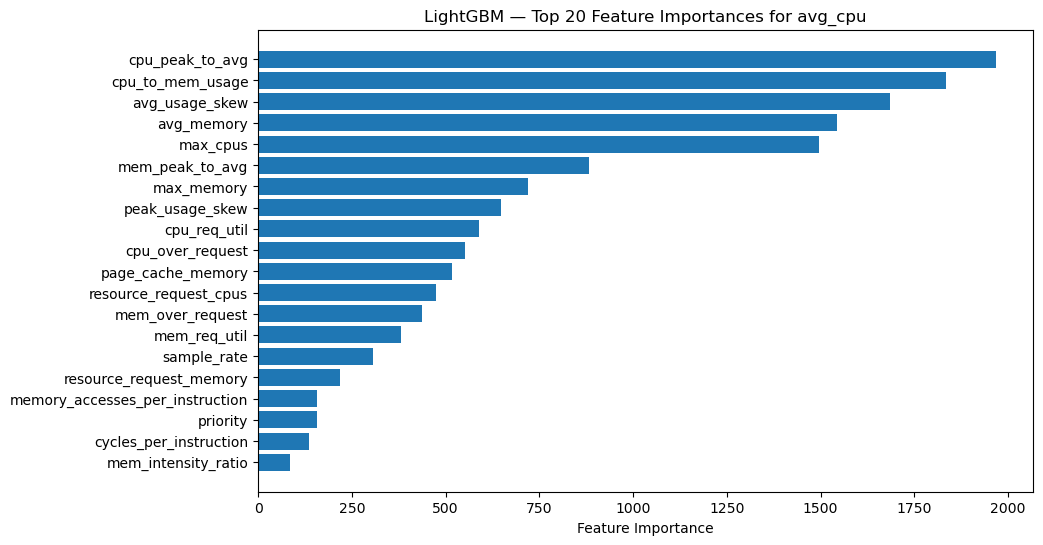

In [22]:

top_n = 20
top_idx = sorted_idx[:top_n]

top_features = [features[i] for i in top_idx]
top_values = importances[top_idx]

plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_values)
plt.yticks(range(top_n), top_features)
plt.xlabel("Feature Importance")
plt.title("LightGBM — Top 20 Feature Importances for avg_cpu")
plt.gca().invert_yaxis()   # highest importance at the top
plt.show()

## Interpretation of Feature Importance Results

Across the three models (Random Forest, XGBoost, and LightGBM), a consistent
pattern emerges. All models agree that the strongest predictors of CPU usage
come from **usage-derived features** rather than raw resource requests.
Metrics that capture workload behavior—such as skew, burstiness, peak-to-average
ratios, and CPU–memory balance—rank far higher than requested CPUs or memory.

In contrast, features like `resource_request_cpus` and
`resource_request_memory` show relatively low importance across all models,
confirming that resource requests are often poor indicators of actual runtime
behavior. Hardware counters also contribute little signal.

Overall, the models collectively reveal that **workload dynamics and efficiency
ratios are far more informative for predicting CPU usage than user-provided
requests or basic metadata**.


## Avg Memory Prediction
We train a LightGBM model to predict `avg_memory` using the engineered
features.


In [23]:
# ==========================
# 1) Feature selection
# ==========================
selected_features = [
    "resource_request_cpus", "resource_request_memory", "assigned_memory",
    "scheduling_class", "priority",
    "avg_cpus", "avg_memory", "max_cpus", "max_memory", "page_cache_memory",
    "cycles_per_instruction", "memory_accesses_per_instruction", "sample_rate",
    "duration_s", "log_duration_s", "cpu_req_util", "mem_req_util",
    "cpu_over_request", "mem_over_request", "cpu_peak_to_avg", "mem_peak_to_avg",
    "cpu_efficiency_proxy", "mem_intensity_ratio", "cpu_to_mem_usage",
    "page_cache_fraction", "cpu_to_mem_request", "avg_usage_skew",
    "peak_usage_skew",
]

df = df_expanded.copy()

# ==========================
# 2) Define task & target
# ==========================
target = "avg_memory"

# remove target from features to avoid leakage
features = [c for c in selected_features if c != target]

X = df[features]
y = df[target]

# drop rows with NaN target
mask = ~y.isna()
X = X[mask]
y = y[mask]

# ==========================
# 3) Train/test split
# ==========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ==========================
# 4) Median imputation
# ==========================
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

# ==========================
# 5) LightGBM regressor
# ==========================
lgbm_mem = LGBMRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=-1,          # let LGBM decide
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgbm_mem.fit(X_train_imp, y_train)

# ==========================
# 6) Evaluation
# ==========================
y_pred = lgbm_mem.predict(X_test_imp)

print("LightGBM Memory Model (target = avg_memory)")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

# ==========================
# 7) Feature importance
# ==========================
importances = lgbm_mem.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

print("\nTop 20 feature importances for avg_memory:")
for idx in sorted_idx[:20]:
    print(f"{features[idx]}: {importances[idx]:.1f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5667
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 25
[LightGBM] [Info] Start training from score 0.004002
LightGBM Memory Model (target = avg_memory)
MAE: 5.2764221974363266e-05
R2: 0.9967594267690991

Top 20 feature importances for avg_memory:
max_memory: 2950.0
mem_peak_to_avg: 2087.0
resource_request_memory: 1236.0
cpu_to_mem_usage: 1213.0
cpu_peak_to_avg: 1207.0
resource_request_cpus: 1160.0
mem_req_util: 1160.0
mem_over_request: 1055.0
avg_usage_skew: 983.0
avg_cpus: 958.0
page_cache_memory: 739.0
max_cpus: 708.0
cpu_req_util: 368.0
sample_rate: 342.0
peak_usage_skew: 314.0
cpu_over_request: 290.0
mem_intensity_ratio: 277.0
memory_accesses_per_instruction: 271.0
cycles_per_instruction: 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


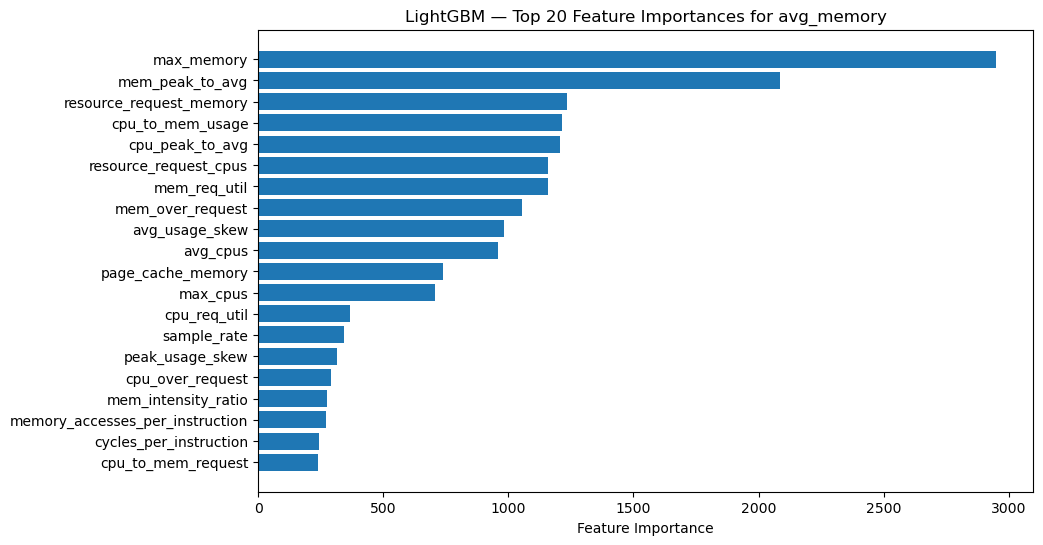

In [24]:

top_n = 20
top_idx = sorted_idx[:top_n]

top_features = [features[i] for i in top_idx]
top_values = importances[top_idx]

plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_values)
plt.yticks(range(top_n), top_features)
plt.xlabel("Feature Importance")
plt.title("LightGBM — Top 20 Feature Importances for avg_memory")
plt.gca().invert_yaxis()   # highest importance at the top
plt.show()

## Max Memory Prediction

### Why Predict Max Memory?

Peak (max) memory usage is one of the most critical resources in a large-scale
cluster. Unlike CPU, memory cannot be easily throttled or oversubscribed
without risking failures. If a container exceeds its allocated memory, it can
trigger OOM kills, evictions, or even disrupt other workloads on the same
machine.

By predicting **max_memory**, we can:

- detect when users are heavily over-requesting memory,
- identify workloads that consistently under-request and are at risk of OOM,
- understand real memory demand patterns across different job types,
- and ultimately propose strategies for more accurate memory allocation.

Accurate peak-memory prediction is therefore essential for improving
resource efficiency, reducing wasted memory, and preventing memory-related
failures in real cluster scheduling.


In [25]:
# ==========================
# 1) Feature selection
# ==========================
selected_features = [
    "resource_request_cpus", "resource_request_memory", "assigned_memory",
    "scheduling_class", "priority",
    "avg_cpus", "avg_memory", "max_cpus", "max_memory", "page_cache_memory",
    "cycles_per_instruction", "memory_accesses_per_instruction", "sample_rate",
    "duration_s", "log_duration_s", "cpu_req_util", "mem_req_util",
    "cpu_over_request", "mem_over_request", "cpu_peak_to_avg", "mem_peak_to_avg",
    "cpu_efficiency_proxy", "mem_intensity_ratio", "cpu_to_mem_usage",
    "page_cache_fraction", "cpu_to_mem_request", "avg_usage_skew",
    "peak_usage_skew",
]

df = df_expanded.copy()

# ==========================
# 2) Define target
# ==========================
target = "max_memory"

# remove target from features to avoid leakage
features = [c for c in selected_features if c != target]

X = df[features]
y = df[target]

# drop rows with NaN target
mask = ~y.isna()
X = X[mask]
y = y[mask]

# ==========================
# 3) Train/test split
# ==========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ==========================
# 4) Median imputation
# ==========================
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

# ==========================
# 5) LightGBM regressor
# ==========================
lgbm_maxmem = LGBMRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=-1,          # let LightGBM decide
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgbm_maxmem.fit(X_train_imp, y_train)

# ==========================
# 6) Evaluation
# ==========================
y_pred = lgbm_maxmem.predict(X_test_imp)

print("LightGBM Peak Memory Model (target = max_memory)")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

# ==========================
# 7) Feature importance
# ==========================
importances = lgbm_maxmem.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

print("\nTop 20 feature importances for max_memory:")
for idx in sorted_idx[:20]:
    print(f"{features[idx]}: {importances[idx]:.1f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5667
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 25
[LightGBM] [Info] Start training from score 0.004814
LightGBM Peak Memory Model (target = max_memory)
MAE: 8.940632880842723e-05
R2: 0.9962515365451167

Top 20 feature importances for max_memory:
avg_memory: 2664.0
mem_peak_to_avg: 2470.0
mem_req_util: 1393.0
resource_request_cpus: 1185.0
resource_request_memory: 1136.0
max_cpus: 1017.0
cpu_to_mem_usage: 1002.0
mem_over_request: 948.0
cpu_peak_to_avg: 897.0
avg_usage_skew: 825.0
avg_cpus: 761.0
page_cache_memory: 726.0
peak_usage_skew: 631.0
cpu_req_util: 434.0
cpu_over_request: 407.0
cpu_to_mem_request: 383.0
cycles_per_instruction: 272.0
memory_accesses_per_instruction: 236.0
mem_intensi

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


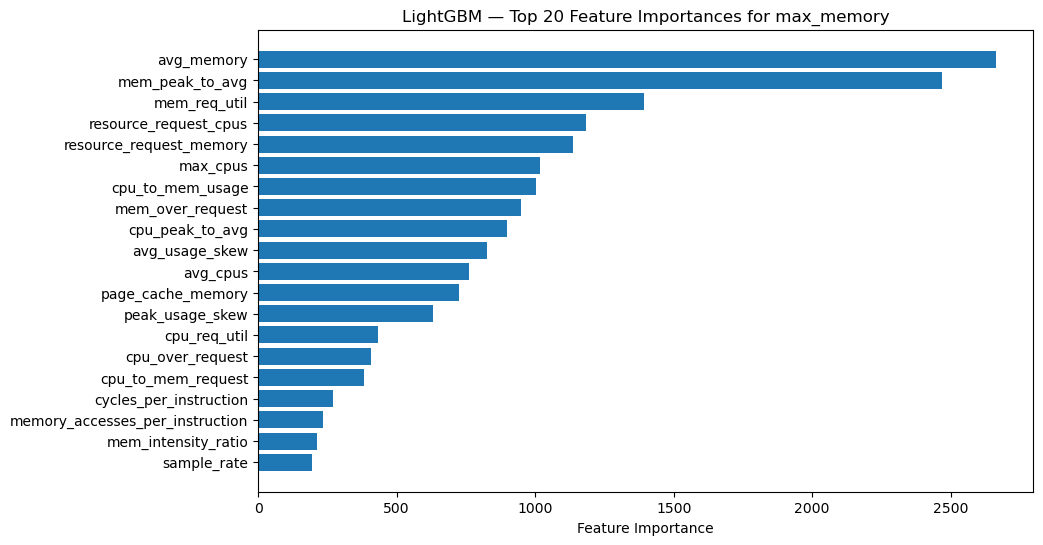

In [26]:

top_n = 20
top_idx = sorted_idx[:top_n]

top_features = [features[i] for i in top_idx]
top_values = importances[top_idx]

plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_values)
plt.yticks(range(top_n), top_features)
plt.xlabel("Feature Importance")
plt.title("LightGBM — Top 20 Feature Importances for max_memory")
plt.gca().invert_yaxis()   # highest importance at the top
plt.show()

## Using only Features that Scheduler can see in realtime

Up to this point, the models used post-execution usage metrics (avg/max CPU,
memory, efficiency ratios, CPI/MAI, etc.), which are helpful for analysis but
**cannot be known at the moment a scheduler must make a decision**. In a real
cluster, the scheduler only sees information provided at job submission time,
such as:

- requested CPUs and memory  
- job priority and scheduling class  
- collection type and user-level metadata  
- submission time (hour/day patterns)

To reflect what is *actually available in production*, we now restrict the
feature set to **scheduler-visible inputs only**. This gives a realistic lower
bound on how well resource usage can be predicted using information the
scheduler truly has at runtime.


### Target : avg_cpus

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

df = df_expanded.copy()

# ================================================================
# 1. ENGINEER ONLY SCHEDULER-VISIBLE FEATURES
# ================================================================

HOUR_NS = 3600 * 10**9
DAY_NS = 24 * HOUR_NS

df["start_hour"] = (df["start_time"] // HOUR_NS) % 24
df["start_day_mod7"] = (df["start_time"] // DAY_NS) % 7

scheduler_feature_cols = [
    "resource_request_cpus",
    "resource_request_memory",
    "priority",
    "scheduling_class",
    "collection_type",
    "cluster",
    "vertical_scaling",
    "scheduler",
    "start_hour",
    "start_day_mod7",
]

# Keep only columns that exist
scheduler_feature_cols = [c for c in scheduler_feature_cols if c in df.columns]

# ================================================================
# 2. FORCE NUMERIC TYPES
# ================================================================
for col in scheduler_feature_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df["avg_cpus"] = pd.to_numeric(df["avg_cpus"], errors="coerce")

# ================================================================
# 3. BUILD MODEL DATAFRAME (DROP NaNs)
# ================================================================
TARGET_COL = "avg_cpus"

use_cols = scheduler_feature_cols + [TARGET_COL]
df_model = df[use_cols].dropna()

X = df_model[scheduler_feature_cols]
y = df_model[TARGET_COL]

print("Scheduler-visible features:", scheduler_feature_cols)
print("Samples used:", len(df_model))

# ================================================================
# 4. TRAIN/TEST SPLIT
# ================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ================================================================
# 5. RANDOM FOREST MODEL
# ================================================================
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    random_state=42,
)

rf.fit(X_train, y_train)

# ================================================================
# 6. EVALUATION
# ================================================================
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nScheduler-only model (target = {TARGET_COL})")
print(f"MAE: {mae:.6f}")
print(f"R2:  {r2:.4f}")

# ================================================================
# 7. FEATURE IMPORTANCE
# ================================================================
importances = rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

print("\nFeature Importances:")
for idx in sorted_idx:
    print(f"{scheduler_feature_cols[idx]}: {importances[idx]:.4f}")


Scheduler-visible features: ['resource_request_cpus', 'resource_request_memory', 'priority', 'scheduling_class', 'collection_type', 'vertical_scaling', 'scheduler', 'start_hour', 'start_day_mod7']
Samples used: 90000

Scheduler-only model (target = avg_cpus)
MAE: 0.004724
R2:  0.4630

Feature Importances:
resource_request_cpus: 0.6400
resource_request_memory: 0.2649
priority: 0.0767
scheduling_class: 0.0129
vertical_scaling: 0.0055
scheduler: 0.0000
collection_type: 0.0000
start_day_mod7: 0.0000
start_hour: 0.0000


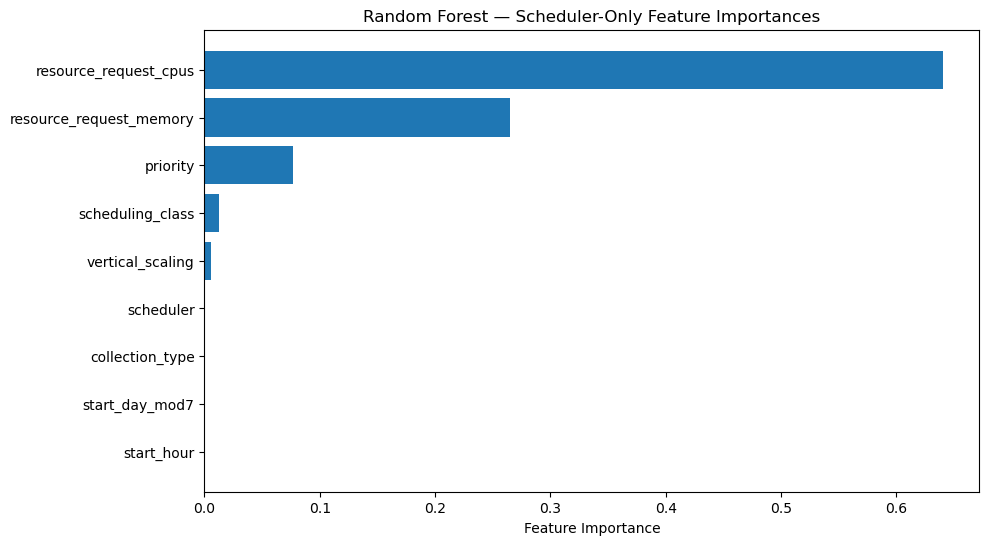

In [28]:
# --- Plot Scheduler-Only Feature Importances (Random Forest) ---

import matplotlib.pyplot as plt
import numpy as np

top_n = len(scheduler_feature_cols)  # or change to 10/20 if you want top-k
top_idx = sorted_idx[:top_n]

top_features = [scheduler_feature_cols[i] for i in top_idx]
top_values = importances[top_idx]

plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_values)
plt.yticks(range(top_n), top_features)
plt.xlabel("Feature Importance")
plt.title("Random Forest — Scheduler-Only Feature Importances")
plt.gca().invert_yaxis()  # highest at top
plt.show()


### XGBoost Model

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor

# ================================================================
# 0. Start from your expanded dataframe
# ================================================================
df = df_expanded.copy()

# ================================================================
# 1. ENGINEER ONLY SCHEDULER-VISIBLE FEATURES
#    (things known at or before submission)
# ================================================================

HOUR_NS = 3600 * 10**9
DAY_NS = 24 * HOUR_NS

df["start_hour"] = (df["start_time"] // HOUR_NS) % 24
df["start_day_mod7"] = (df["start_time"] // DAY_NS) % 7

scheduler_feature_cols = [
    "resource_request_cpus",
    "resource_request_memory",
    "priority",
    "scheduling_class",
    "collection_type",
    "cluster",
    "vertical_scaling",
    "scheduler",
    "start_hour",
    "start_day_mod7",
]

# Keep only columns that actually exist
scheduler_feature_cols = [c for c in scheduler_feature_cols if c in df.columns]

# ================================================================
# 2. FORCE NUMERIC TYPES (critical!)
# ================================================================
for col in scheduler_feature_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df["avg_cpus"] = pd.to_numeric(df["avg_cpus"], errors="coerce")

# ================================================================
# 3. BUILD MODELING DATAFRAME (DROP NaNs)
# ================================================================
TARGET_COL = "avg_cpus"

use_cols = scheduler_feature_cols + [TARGET_COL]
df_model = df[use_cols].dropna()

X = df_model[scheduler_feature_cols]
y = df_model[TARGET_COL]

print("Scheduler-visible features:", scheduler_feature_cols)
print("Samples used:", len(df_model))

# ================================================================
# 4. TRAIN / TEST SPLIT
# ================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ================================================================
# 5. XGBoost REGRESSOR (scheduler-usable model)
# ================================================================
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=42,
)

xgb.fit(X_train, y_train)

# ================================================================
# 6. EVALUATE
# ================================================================
y_pred = xgb.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nXGBoost scheduler-only model (target = {TARGET_COL})")
print(f"MAE: {mae:.6f}")
print(f"R2:  {r2:.4f}")

# ================================================================
# 7. FEATURE IMPORTANCE
# ================================================================
importances = xgb.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

print("\nXGBoost Feature Importances (scheduler-visible only):")
for idx in sorted_idx:
    print(f"{scheduler_feature_cols[idx]}: {importances[idx]:.4f}")


Scheduler-visible features: ['resource_request_cpus', 'resource_request_memory', 'priority', 'scheduling_class', 'collection_type', 'vertical_scaling', 'scheduler', 'start_hour', 'start_day_mod7']
Samples used: 90000

XGBoost scheduler-only model (target = avg_cpus)
MAE: 0.004834
R2:  0.4319

XGBoost Feature Importances (scheduler-visible only):
resource_request_cpus: 0.3389
resource_request_memory: 0.2957
priority: 0.1786
scheduling_class: 0.1407
vertical_scaling: 0.0413
scheduler: 0.0036
collection_type: 0.0012
start_day_mod7: 0.0000
start_hour: 0.0000


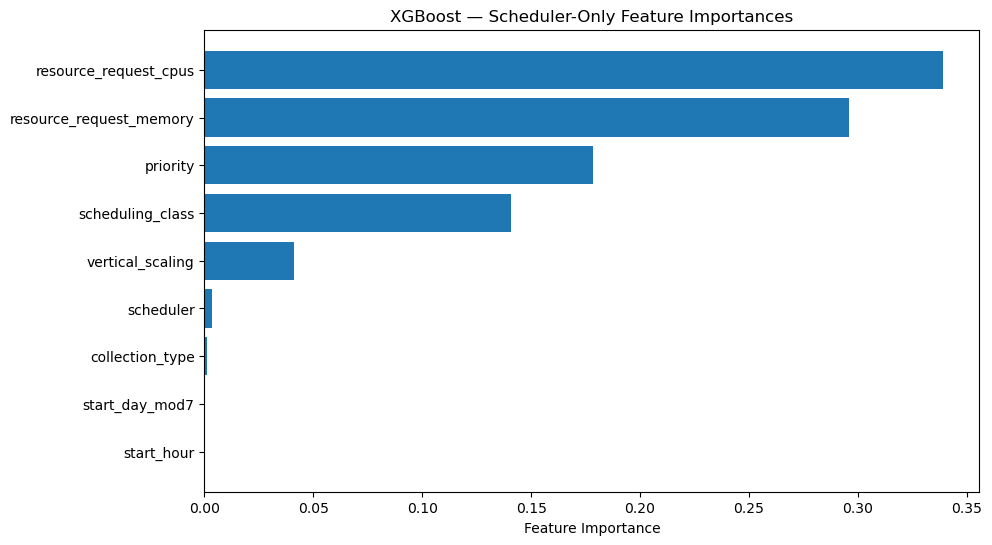

In [30]:

# Select indices in importance-sorted order (already computed as sorted_idx)
top_idx = sorted_idx  # all features; change to sorted_idx[:10] for top 10

top_features = [scheduler_feature_cols[i] for i in top_idx]
top_values = importances[top_idx]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_values)), top_values)
plt.yticks(range(len(top_values)), top_features)
plt.xlabel("Feature Importance")
plt.title("XGBoost — Scheduler-Only Feature Importances")
plt.gca().invert_yaxis()   # highest importance at top
plt.show()

## Key Findings

### 1. Scheduler-visible inputs provide limited predictive power
Models trained only on scheduler-visible information (requested CPUs/memory,
scheduling class, priority, and submission time) show moderate accuracy.
Random Forest and XGBoost achieve R² values around **0.35–0.50**, indicating that
these inputs capture only part of the variance in actual workload behavior.
This reflects the real-world challenge that resource requests and basic metadata
do not reliably describe true runtime usage.

### 2. Resource requests dominate feature importance
Across all scheduler-only models, `resource_request_memory` and
`resource_request_cpus` consistently appear as the strongest predictors.
However, even these signals show weak correlation with actual usage, reinforcing
that over-provisioning and under-provisioning are common in the dataset and that
scheduler-visible features alone are insufficient for accurate prediction.


## Roadmap: Improving Real-Time Scheduling Model Performance

To improve the R² score of the real-time model in the final report, we will
extend the feature set and modeling approach while staying within the
constraints of real-time (submission-time) metadata:

1. **Engineer stronger features**
   - Add ratios and interaction features (e.g., CPU/Memory request ratios, log-scaled request sizes).
   - Encode categorical fields more effectively (scheduling_class, priority, job type).

2. **Incorporate historical behavior**
   - Use simple aggregates from past jobs of the same user, job type, or collection.
   - These are still real-time friendly because they rely only on completed workloads.

3. **Segment the dataset**
   - Build separate models for different scheduling classes or priorities.
   - More homogeneous groups reduce variance and improve predictive accuracy.

4. **Tune and test stronger models**
   - Evaluate optimized LightGBM, XGBoost, and CatBoost.
   - Perform targeted hyperparameter tuning to improve depth, learning rate, and tree structure.

### How these results will be used
The improved prediction models will help identify which real-time signals are
most predictive of actual CPU and memory usage. These insights will guide
recommendations for:
- more accurate resource request policies,
- improved admission and placement strategies,
- auto-adjustment of requests for certain job types,
- and better prioritization rules for under/over-provisioned workloads.

Together, these steps will form a practical set of strategies for enhancing
resource efficiency in large-scale cluster scheduling.
